#Clasificacion de preguntas para asistente legal

In [38]:
# Instalar librerías necesarias
!pip install -q -U transformers datasets

In [39]:
# ============================
# Importar librerías
# ============================
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [40]:
# ============================
# Crear dataset
# ============================
data = [
    # Contratos
    ("¿Cómo redactar una cláusula de confidencialidad en un contrato de prestación de servicios?", "Contratos"),
    ("¿Es obligatorio registrar un contrato de arrendamiento ante notario?", "Contratos"),
    ("¿Qué pasa si un contrato no especifica la duración del servicio?", "Contratos"),
    ("¿Cómo incluir cláusulas de penalización por incumplimiento en un contrato?", "Contratos"),
    ("¿Cuál es la diferencia entre un contrato indefinido y uno temporal?", "Contratos"),
    ("¿Qué debe contener un contrato de trabajo en España para ser válido?", "Contratos"),
    ("¿Puedo modificar unilateralmente un contrato ya firmado?", "Contratos"),
    ("¿Qué elementos invalidan un contrato de compraventa?", "Contratos"),
    ("¿Cómo asegurar la validez de un contrato firmado digitalmente?", "Contratos"),
    ("¿Es legal incluir una cláusula de exclusividad en un contrato mercantil?", "Contratos"),

    # Derecho Laboral
    ("¿Cuántos días de vacaciones corresponden por ley en Colombia?", "Derecho Laboral"),
    ("¿Cómo calcular la liquidación de un trabajador despedido en España?", "Derecho Laboral"),
    ("¿Es legal contratar a un trabajador sin firmar contrato escrito?", "Derecho Laboral"),
    ("¿Qué derechos tiene un empleado si lo despiden sin justa causa?", "Derecho Laboral"),
    ("¿Cuál es la diferencia entre indemnización y liquidación?", "Derecho Laboral"),
    ("¿Cuántas horas extras puede hacer un trabajador por semana?", "Derecho Laboral"),
    ("¿Cómo funciona el permiso por maternidad en Colombia?", "Derecho Laboral"),
    ("¿Es obligatorio pagar aguinaldo en todos los países de LATAM?", "Derecho Laboral"),
    ("¿Qué procedimiento debe seguir una empresa para un despido colectivo?", "Derecho Laboral"),
    ("¿Qué hacer si un empleado no cumple con su horario laboral?", "Derecho Laboral"),

    # Derecho Tributario
    ("¿Qué tasa de IVA aplica en España para servicios digitales?", "Derecho Tributario"),
    ("¿Cómo declarar impuestos siendo autónomo en México?", "Derecho Tributario"),
    ("¿Qué diferencias hay entre ISR e IVA?", "Derecho Tributario"),
    ("¿Es deducible el gasto en equipos informáticos para una pyme?", "Derecho Tributario"),
    ("¿Cómo funciona la retención de impuestos para trabajadores independientes?", "Derecho Tributario"),
    ("¿Qué sanciones existen por no presentar la declaración anual?", "Derecho Tributario"),
    ("¿Cuáles son las obligaciones fiscales de una startup en España?", "Derecho Tributario"),
    ("¿Se puede recuperar el IVA pagado en importaciones?", "Derecho Tributario"),
    ("¿Cómo evitar la doble tributación en LATAM y Europa?", "Derecho Tributario"),
    ("¿Qué impuestos se pagan por dividendos recibidos?", "Derecho Tributario"),
]

In [41]:
# Mapear etiquetas a números
label2id = {"Contratos": 0, "Derecho Laboral": 1, "Derecho Tributario": 2}
id2label = {v: k for k, v in label2id.items()}

data_dict = [{"text": x, "label": label2id[y]} for x, y in data]
dataset = Dataset.from_list(data_dict)

In [42]:
# ============================
# Split train / test
# ============================
dataset_split = dataset.train_test_split(test_size=0.3, seed=42)

# Asignar datasets
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

In [43]:
# ============================
# Tokenización
# ============================
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [45]:
# ============================
# Cargar modelo
# ============================
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
#==============
# Accuracy
#==============

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [62]:
# ============================
# Entrenamiento
# ============================
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
try:
  print("Entrenando...")
  trainer.train()
  print("Entrenamiento completado")
except Exception as e:
  print("Error al entrenar")

/tmp/ipython-input-3961835706.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenando...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.650900,1.447736,0.222222,0.092593,0.222222,0.120635
2,0.896500,1.387908,0.222222,0.092593,0.222222,0.120635
3,0.613700,1.361454,0.222222,0.126984,0.222222,0.138889
4,0.641700,1.344292,0.222222,0.126984,0.222222,0.138889
5,0.444700,1.416275,0.222222,0.126984,0.222222,0.138889
6,0.404400,1.478823,0.222222,0.126984,0.222222,0.138889
7,0.342600,1.505878,0.222222,0.126984,0.222222,0.138889
8,0.362600,1.512841,0.222222,0.126984,0.222222,0.138889


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Entrenamiento completado


In [74]:
# ============================
# Prueba de predicción
# ============================

#======================== Contratos ===============================
text = "¿Qué ocurre si una de las partes no firma un contrato digital?"
#text = "¿Un contrato verbal tiene validez legal en España?"
#text = "¿Es posible incluir cláusulas de arbitraje en un contrato mercantil?"


#==================== Derecho Laboral ==========================
#text = "¿Cuántos días de permiso corresponden por matrimonio en México?"
#text = "¿Puede una empresa descontar el salario por llegadas tarde?"
#text = "¿Qué derechos tiene un trabajador freelance en Colombia?"

# ================ Derecho Tributario ============================
#text = "¿Cuándo se debe presentar la declaración de renta en Colombia?"
#text = "¿Cómo se calculan los impuestos de una pyme en México?"
#text = "¿Es deducible el gasto en transporte para trabajadores en España?"



inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Mover las entradas al mismo dispositivo que el modelo (GPU o CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}
model.to(device)

outputs = model(**inputs)
pred = torch.argmax(outputs.logits, dim=1).item()

print("Pregunta:", text)
print("Predicción:", id2label[pred])
print("Probabilidades:", torch.softmax(outputs.logits, dim=1).tolist()[0])

Pregunta: ¿Qué ocurre si una de las partes no firma un contrato digital?
Predicción: Contratos
Probabilidades: [0.5422500371932983, 0.3046339750289917, 0.15311601758003235]


metricas finales:  {'accuracy': 0.8571428571428571, 'precision': 0.8961038961038962, 'recall': 0.8571428571428571, 'f1': 0.8255639097744362}
Nuestro modelo legal acertó en: 85.71 % de las preguntas nuevas


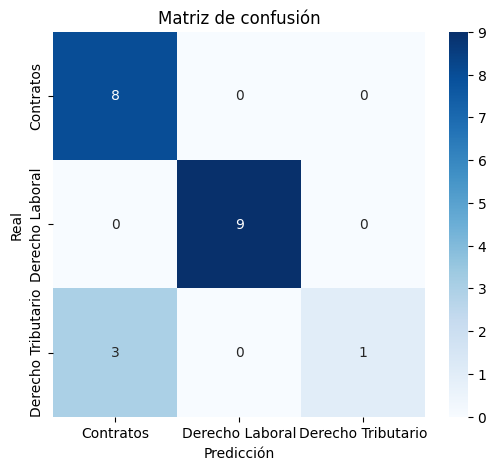

In [75]:
# Evaluar dataset
#predictions = trainer.predict(eval_dataset)
predictions = trainer.predict(train_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

#accuracy y metricas
metrics = compute_metrics((predictions.predictions, y_true))
print("metricas finales: ", metrics)

print("Nuestro modelo legal acertó en:", round(100*metrics["accuracy"],2), "% de las preguntas nuevas")


# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()